#Project | Advanced Computer Vision

##Description

In this hands-on project, the goal is to build a face detection model which includes building a face detector to locate the position of a face in an image.

Notebook & Dataset: WIDER Face Dataset

Face_detection_Questions_Project_CV.ipynb

Project Description - Face Detection.pdf   

Dataset: WIDER Face Dataset : images (1).npy

WIDER FACE dataset is a face detection benchmark dataset, of which images are selected from the publicly available WIDER dataset. 

This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images.

In this project, we are using 409 images and around 1000 faces for ease of computation.

We will be using transfer learning on an already trained model to build our detector. We will perform transfer learning on Mobile Net model which is already trained to perform object detection. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face detection. To be able to train the Mobile Net model for face detection, we will be using WIDER FACE dataset which already has the bounding box data for various images with a single face and multiple faces. The output of the model is the bounding box data which gives the location of the face in an image. We learn to build a face detection model using Keras supported by Tensorflow.

###Reference

Acknowledgment for the datasets. http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

Mobile Net paper: https://arxiv.org/pdf/1704.04861.pdf

###Overview

In this problem, we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, we are particularly interested in detecting faces in a given image. Below are the steps involved in the project.

- Load the dataset given in form .npy format.
- Create Features(images) and labels(mask) using that data.
- Load the pre-trained model and weights.
- Create a model using the above model.
- Define the Dice Coefficient and Loss function.
- Compile and fit the model.
- Evaluate the model.


# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# IMPORT LIBRARIES AND PACKAGES

import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import math

import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [4]:
%tensorflow_version 2.x
tf.random.set_seed(42)
print("Tensorflow loaded successfully")
print(tf.__version__)

Tensorflow loaded successfully
2.2.0-rc2


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [6]:
%cd /content/drive/My Drive/Great_Lakes_Assignments/12_Adv_Computer_Vision_Face_Detection_R10_Project

/content/drive/My Drive/Great_Lakes_Assignments/12_Adv_Computer_Vision_Face_Detection_R10_Project


In [7]:
!ls -l

total 1327389
-rw------- 1 root root     535320 Apr  5 14:22  ACV_Face_Detection_R10_Project1.ipynb
-rw------- 1 root root    1457014 Apr  8 09:54  AdvanceCompVision_Face_Detection_R10_Project.ipynb
-rw------- 1 root root      10061 Apr  8 06:23  Face_detection_Questions_Project_CV.ipynb
-rw------- 1 root root      38293 Apr  8 06:31  Image_Segmentation.ipynb
-rw------- 1 root root 1356868279 Mar 31 12:59  Images.npy
-rw------- 1 root root     113912 Mar 30 19:14 'Project Description - Face Detection.pdf'
-rw------- 1 root root      44701 Apr  8 09:26  Test_Image1.jpg
-rw------- 1 root root      64222 Apr  8 06:57  Test_Image2.jpg
-rw------- 1 root root     112622 Apr  8 09:26  Test_Image3.jpg


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
data = np.load('Images.npy',allow_pickle=True)

In [9]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  (2 marks)

In [10]:
data[10]

array([array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [6, 6, 6]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [6, 6, 6]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}])],


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [12]:
#Features as X_Train and Labels as masks

#Labels
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_HEIGHT))
#Features
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

print("Features - X_train and Labels - masks created successfully")

Features - X_train and Labels - masks created successfully


### Print the shape of X_train and mask array  (1 mark)

In [13]:
X_train.shape

(409, 224, 224, 3)

In [14]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

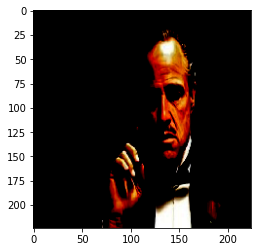

In [15]:
#Print image array and sample image
n = 10
print(X_train[n])
plt.imshow(X_train[n]);

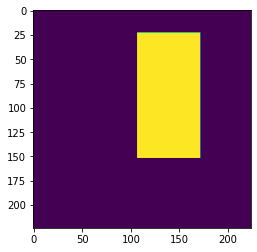

In [16]:
plt.imshow(masks[n]);

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
def create_model(trainable=True):
    #Load MobileNet Model
    model = tf.keras.applications.mobilenet.MobileNet(include_top=False, #Should we include classification Layers
                                                      weights='imagenet', #Load imagenet weights, 'None' will load random weights
                                                      input_shape=(IMAGE_WIDTH,IMAGE_WIDTH,3), alpha=1.0 ) #Input image size
    for layer in model.layers:
        layer.trainable = trainable
    
    # UNET architecture layers
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    # Concatenation of features
    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    # Upsampling is done to match the output size with the size of the lables 224 by 224 in this case.
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="relu")(x)
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = UpSampling2D()(x)
    x = Reshape((IMAGE_WIDTH,IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [18]:
tf.keras.backend.clear_session()
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=False)
# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [21]:
tf.keras.backend.clear_session()

# Give trainable=True as argument, for training of lower layers to get high accuracy
model = create_model(trainable=True)
model.summary()

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model_{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
EPOCHS = 200
BATCH_SIZE = 1
THREADS = 1

train_data = X_train
validation_data = masks

In [24]:
model.fit(x=train_data, y=validation_data, epochs=EPOCHS, batch_size= BATCH_SIZE,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
406/409 [============================>.] - ETA: 0s - loss: 1.6220 - dice_coefficient: 0.3183
Epoch 00001: loss improved from inf to 1.61937, saving model to Model_1.62.h5
409/409 [==============================] - 7s 17ms/step - loss: 1.6194 - dice_coefficient: 0.3188 - lr: 1.0000e-04
Epoch 2/200
408/409 [============================>.] - ETA: 0s - loss: 1.2570 - dice_coefficient: 0.3987
Epoch 00002: loss improved from 1.61937 to 1.25597, saving model to Model_1.26.h5
409/409 [==============================] - 7s 17ms/step - loss: 1.2560 - dice_coefficient: 0.3989 - lr: 1.0000e-04
Epoch 3/200
409/409 [==============================] - ETA: 0s - loss: 1.1086 - dice_coefficient: 0.4419
Epoch 00003: loss improved from 1.25597 to 1.10858, saving model to Model_1.11.h5
409/409 [==============================] - 7s 17ms/step - loss: 1.1086 - dice_coefficient: 0.4419 - lr: 1.0000e-04
Epoch 4/200
407/409 [============================>.] - ETA: 0s - loss: 0.9702 - dice_coefficient: 

dict_keys(['loss', 'dice_coefficient', 'lr'])


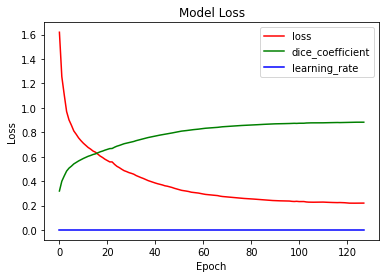

In [25]:
# list all data in history
print(model.history.history.keys())

# Summary - History for loss

plt.plot(model.history.history['loss'], color = 'red')
plt.plot(model.history.history['dice_coefficient'], color = 'green')
plt.plot(model.history.history['lr'], color = 'blue')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'dice_coefficient', 'learning_rate'], loc='upper right')
plt.show();

## From the above plot we can see that the loss is getting stabilised around 0.21888 and is not further reducing even when the epochs are increased.

### Get the predicted mask for a sample image   (3 marks)

In [57]:
#Checking the models saved on the current path.
!ls -l

total 1391410
-rw------- 1 root root     535320 Apr  5 14:22  ACV_Face_Detection_R10_Project1.ipynb
-rw------- 1 root root    1311420 Apr  8 10:47  AdvanceCompVision_Face_Detection_R10_Project.ipynb
-rw------- 1 root root      10061 Apr  8 06:23  Face_detection_Questions_Project_CV.ipynb
-rw------- 1 root root      38293 Apr  8 06:31  Image_Segmentation.ipynb
-rw------- 1 root root 1356868279 Mar 31 12:59  Images.npy
-rw------- 1 root root   13140144 Apr  8 10:13  Model_0.22.h5
-rw------- 1 root root   13140144 Apr  8 10:11  Model_0.23.h5
-rw------- 1 root root   13140144 Apr  8 10:09  Model_0.24.h5
-rw------- 1 root root   13140144 Apr  8 10:08  Model_0.25.h5
-rw------- 1 root root   13140144 Apr  8 10:08  Model_0.26.h5
-rw------- 1 root root     113912 Mar 30 19:14 'Project Description - Face Detection.pdf'
-rw------- 1 root root      44701 Apr  8 09:26  Test_Image1.jpg
-rw------- 1 root root      64222 Apr  8 06:57  Test_Image2.jpg
-rw------- 1 root root     112622 Apr  8 09:26  Tes

In [26]:
WEIGHTS_FILE = "Model_0.22.h5"

model = create_model()
model.load_weights(WEIGHTS_FILE)

print('Done')

Done


In [0]:
n=10

print("Example of Input_Image, Actual_Mask, and Predicted_Mask")
img = X_train[n]
label = masks[n]
# Predicted Mask for a sample image
predicted_label = model.predict(x=np.array([img]))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Input image')

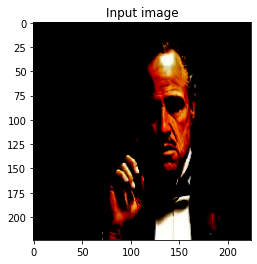

In [69]:
#Plotting Original Image
plt.imshow(img)
plt.title("Input image")

Text(0.5, 1.0, 'Actual Mask')

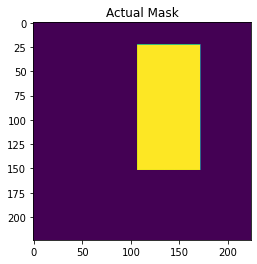

In [68]:
#Plotting Actual Mask of sample image
plt.imshow(label)
plt.title("Actual Mask")

Text(0.5, 1.0, 'Predicted Mask')

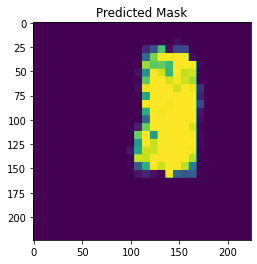

In [67]:
#Plotting Predicted Mask of sample image
plt.imshow(predicted_label)
plt.title("Predicted Mask")

### Impose the mask on the image (3 marks)

In [31]:
#Check the uploaded test images on the current path

!ls -l

total 1391620
-rw------- 1 root root     535320 Apr  5 14:22  ACV_Face_Detection_R10_Project1.ipynb
-rw------- 1 root root    1526393 Apr  8 10:23  AdvanceCompVision_Face_Detection_R10_Project.ipynb
-rw------- 1 root root      10061 Apr  8 06:23  Face_detection_Questions_Project_CV.ipynb
-rw------- 1 root root      38293 Apr  8 06:31  Image_Segmentation.ipynb
-rw------- 1 root root 1356868279 Mar 31 12:59  Images.npy
-rw------- 1 root root   13140144 Apr  8 10:13  Model_0.22.h5
-rw------- 1 root root   13140144 Apr  8 10:11  Model_0.23.h5
-rw------- 1 root root   13140144 Apr  8 10:09  Model_0.24.h5
-rw------- 1 root root   13140144 Apr  8 10:08  Model_0.25.h5
-rw------- 1 root root   13140144 Apr  8 10:08  Model_0.26.h5
-rw------- 1 root root     113912 Mar 30 19:14 'Project Description - Face Detection.pdf'
-rw------- 1 root root      44701 Apr  8 09:26  Test_Image1.jpg
-rw------- 1 root root      64222 Apr  8 06:57  Test_Image2.jpg
-rw------- 1 root root     112622 Apr  8 09:26  Tes

In [0]:
#Define function to Impose the mask on the image

def Impose_Mask(filename,scale_percent,Threshold):# Pass Imagename, percentage of scaling and accuracy threshold
    unscaled = cv2.imread(filename,1)

    # percent of original size
    width = int(unscaled.shape[1] * scale_percent / 100)
    height = int(unscaled.shape[0] * scale_percent / 100)
    dim = (width, height)

    img_org = cv2.resize(unscaled, dim, interpolation = cv2.INTER_AREA)

    image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    
    pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > Threshold), (IMAGE_WIDTH,IMAGE_HEIGHT))

    image2 = image
    image2[:,:,0] = pred_mask*image[:,:,0]
    image2[:,:,1] = pred_mask*image[:,:,1]
    image2[:,:,2] = pred_mask*image[:,:,2]

    out_image = image2

    out_image = cv2.resize(out_image, dim, interpolation = cv2.INTER_AREA)

    return (print("........ Test Image ........"),
           print(),
           cv2_imshow(img_org),
           print(),
           print(".. Imposed Mask on Test Image for Face Detection .."),
           print(),
           cv2_imshow(out_image),
           cv2.waitKey(0),
           cv2.destroyAllWindows())

........ Test Image ........



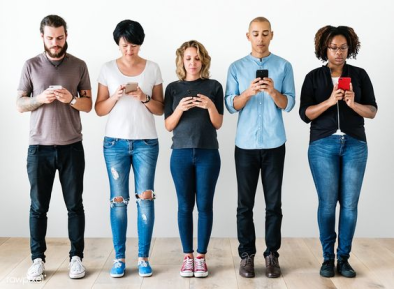


.. Imposed Mask on Test Image for Face Detection ..



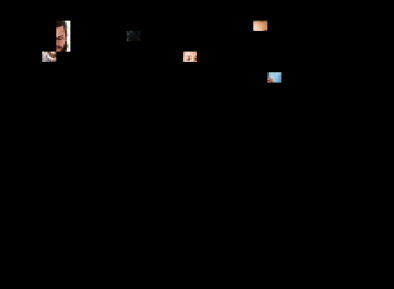

In [38]:
# Impose the mask on the Test Image 1 

Impose_Mask("Test_Image1.jpg",70,0.2);

........ Test Image ........



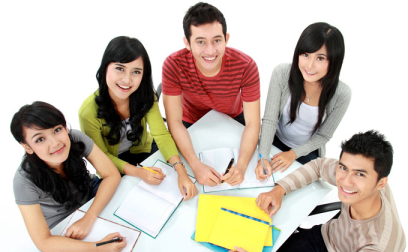


.. Imposed Mask on Test Image for Face Detection ..



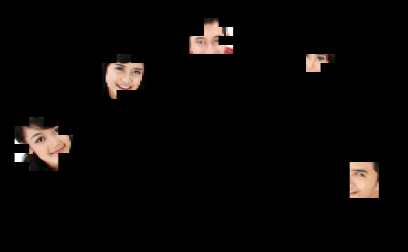

In [39]:
# Impose the mask on the Test Image 2

Impose_Mask("Test_Image2.jpg",60,0.2);

........ Test Image ........



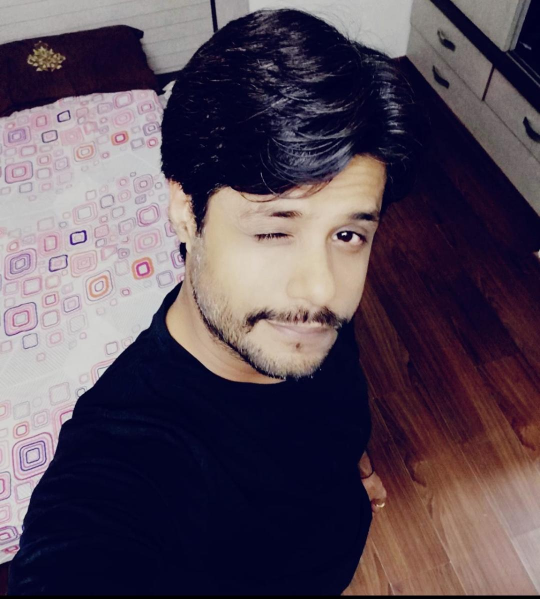


.. Imposed Mask on Test Image for Face Detection ..



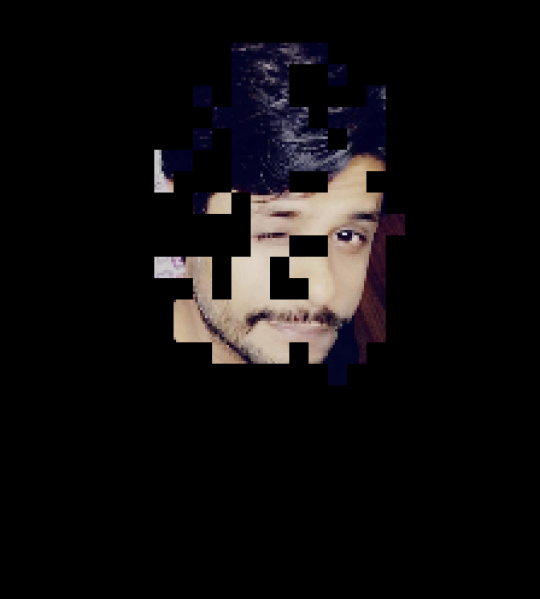

In [43]:
# Impose the mask on the Test Image 3 

Impose_Mask("Test_Image3.jpg",50,0.2);

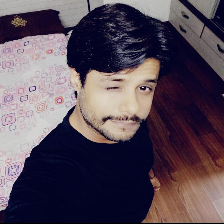

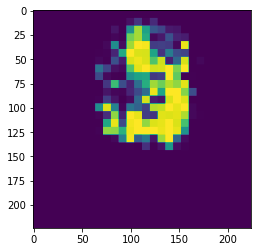

In [56]:
filename = 'Test_Image3.jpg'

unscaled = cv2.imread(filename, 1)
unscaled_img = preprocess_input(np.array(unscaled, dtype=np.float32))

image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
region = model.predict(x=np.array([feat_scaled]))[0]

cv2_imshow(image)
plt.imshow(region)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Summary
- We can clearly see the model is able to detect the face. 
- As the data size for training is only 409 samples which is very less, if we provide good volume of similar data to this model the accuracy of the model will increase, and it will definately give better output.